# Downloading all the covid-positive images through the online data pipeline 

In [1]:
from bs4 import BeautifulSoup
import re
import requests
import shutil

#The webpage we will be downloading from - this can be changed to any online repository
url = "https://github.com/ieee8023/covid-chestxray-dataset/tree/master/images"

#This checks to see if the website is availiable - a 200 request means it was sucessful, a 404 means it wasn't
response = requests.get(url)

#Loading in the raw website data
soup = BeautifulSoup(response.text, "html.parser")

#Finding all the images
tags = soup.find_all(href=re.compile("/ieee8023/covid-chestxray-dataset/blob/master/images/"))

#Setting an array to the links of all the images
links = (set(tag['href'] for tag in tags))

print("We retrieved ", len(links), "images.")

#Creating an array of the links, as well as the names
links_list = []
semi_final_list = []
names_list = []
i = 0

#Populating the arrays
for x in links:  
    links_list.append(x)
    
    a = (links_list[i])[0:33]
    b = (links_list[i])[38:]
    c = a + b
    semi_final_list.append(c)
    names_list.append("Image " + str(i+1))
    i = i+1

#Concatenating strings in order to get the correct final links
links_final = []
for i in range(len(names_list)):
    links_final.append("https://raw.githubusercontent.com" + str(semi_final_list[i]))
    
#Placing all the downloaded images into a file on the desktop
print("Downloading the images into a file on the desktop...")
for i in range(len(names_list)):
    response = requests.get(links_final[i], stream=True)
    file = open("/Users/joshuastapleton/Desktop/Download_Covid/" + str(names_list[i]) + ".jpeg", 'wb')
    response.raw.decode_content = True
    shutil.copyfileobj(response.raw, file)

We retrieved  797 images.


# Downloading covid-negative (ie healthy) x-rays

In [8]:
import webbrowser
print("Download the following data")
webbrowser.open('https://data.mendeley.com/datasets/rscbjbr9sj/2#file-41d542e7-7f91-47f6-9ff2-dd8e5a5a7861')
print("Place the data in a folder called 'NORMAL' on the desktop")

True

# Loading in all the images from the file

In [13]:
import numpy as np
from numpy import asarray
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import os
from os import listdir
import matplotlib.pyplot as plt

os.chdir("/Users/joshuastapleton/Desktop")

# Loading in all the covid-positive images from the file with pillow
covid_positive_images = []
i = 0
print("Loading in all the positive images...")
for filename in listdir('Download_Covid'):
    covid_positive_images.append(Image.open('Download_Covid/' + str(filename)))
    i = i+1
    
# Resize all the images to a standard size
resized_positive_images = []
print("Resizing the loaded positive images...")
for i in range(len(covid_positive_images)):
    resized_positive_images.append(covid_positive_images[i].resize((224, 224))) #THE 224s can be changed in optimization
    
# Convert images to numpy arrays - pixel brightnesses = numerical value in array
covid_positive_images_numpy = []
print("Converting the positive images to numpy arrays...")
for i in range(len(covid_positive_images)):
    covid_positive_images_numpy.append(asarray(resized_positive_images[i].convert(mode='RGB'))) # The 'RGB' simply means color images

# Create a vector of the labels for positive tests -> label = 1
labels_positive = []
print("Creating a vector of positive labels...")
for i in range(len(covid_positive_images)):
    labels_positive.append(1)
    
# Convert the positive data and labels to NumPy arrays while scaling the pixel intensities to the range [0, 1]
labels_positive = np.array(labels_positive)
raw_positive_data = np.array(covid_positive_images_numpy) / 255.0   
    

    
# # Now we do exactly the same thing for all the negative data
    
    
# Loading in all the covid-negative images with pillow
covid_negative_images = []
i = 0
for filename in listdir('NORMAL'):
    covid_negative_images.append(Image.open('NORMAL/' + str(filename)))
    i = i+1

# Resize all the negative images to a standard size
resized_negative_images = []
print("Resizing the loaded negative images...")
for i in range(len(covid_negative_images)):
    resized_negative_images.append(covid_negative_images[i].resize((224, 224))) #THE 224s can be changed in optimization
    
# Convert images to numpy arrays - pixel brightnesses = numerical value in array
print("Converting the negative images to numpy arrays...")
covid_negative_images_numpy = []
for i in range(len(covid_negative_images)):
    covid_negative_images_numpy.append(asarray(resized_negative_images[i].convert(mode='RGB'))) # The 'RGB' simply means color images

# Create a vector of the labels for negative tests -> label = 1
labels_negative = []
print("Creating a vector of negative labels...")
for i in range(len(covid_negative_images)):
    labels_negative.append(0)
    
# Convert the negative data and labels to NumPy arrays while scaling the pixel intensities to the range [0, 1]
labels_negative = np.array(labels_negative)
raw_negative_data = np.array(covid_negative_images_numpy) / 255.0

# Finally, combine the positive and negative data into one big dataset

#Combining the labels
combined_labels = np.append(labels_positive, labels_negative)

#Combining the arrays
combined_data = np.concatenate((raw_positive_data, raw_negative_data), axis=0)

print("The shape of the combined data as an array is: ",combined_data.shape)

Loading in all the positive images...
Resizing the loaded positive images...
Converting the positive images to numpy arrays...
Creating a vector of positive labels...
Resizing the loaded negative images...
Converting the negative images to numpy arrays...
Creating a vector of negative labels...
The shape of the combined data as an array is:  (1224, 224, 224, 3)


# Displaying statistics about the data

Reshaping the combined labels to match dimensions...
Here is an example of some of the standardized images from the dataset:


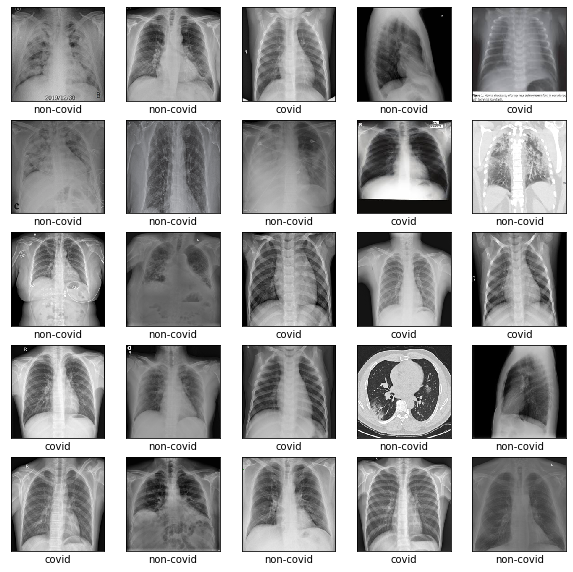

In [14]:
from sklearn.model_selection import train_test_split
#Properly reshaping the combined labels
print("Reshaping the combined labels to match dimensions...")
combined_labels = np.reshape(combined_labels, (combined_labels.shape[0], 1))

(trainX, testX, trainY, testY) = train_test_split(combined_data, combined_labels, test_size=0.10, stratify=combined_labels, random_state=42)

class_names = ['covid', 'non-covid']
print("Here is an example of some of the standardized images from the dataset:")
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(trainX[i], cmap=plt.cm.binary)
    # The covid labels happen to be arrays, 
    # which is why we need the extra index
    plt.xlabel(class_names[trainY[i][0]])
plt.show()

# Building, Training, and Deploying the CNN, with evaluation report by Tensorboard

In [15]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import datasets, layers, models
import tensorboard
import datetime
!rm -rf ./logs/ 
%load_ext tensorboard
    
NAME =  "BigCOVID-CNNbyJosh"
#original model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.summary()

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2))

model.summary()

model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


model.fit(trainX, trainY, epochs=50, validation_data=(testX, testY), callbacks=[tensorboard_callback])

%tensorboard --logdir logs/fit

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        36928     
Total params: 56,320
Trainable params: 56,320
Non-trainable params: 0
_________________________________________________________________
Model: "sequential"
_________________________________________________________________
Layer (type)                 Out

# Simpler Implementation

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 52, 52, 64)        36928     
Total params: 56,320
Trainable params: 56,320
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                

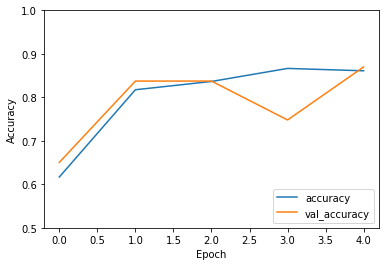

In [16]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import TensorBoard
import datetime
log_dir = "logs\ fit\ " + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)



Name = "LittleCOVID-CNNbyJosh"


model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.summary()

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2))

model.summary()

model.compile(optimizer='nadam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(trainX, trainY, epochs=5, validation_data=(testX, testY),callbacks=[tensorboard_callback])

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(testX, testY, verbose=2)

print(test_acc)